# Run the wavelength and the fringe frame maker notebooks first!

In [1]:
import os
os.environ['OPENTSDB_PYTHON_METRICS_TEST_MODE'] = 'True'

In [2]:
import importlib.resources
import requests
from banzai_floyds import settings
from banzai.utils.stage_utils import run_pipeline_stages
from banzai.utils.fits_utils import download_from_s3
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units

In [3]:
os.environ['DB_ADDRESS'] = 'sqlite:///test_data/test.db'
settings.processed_path= os.path.join(os.getcwd(), 'test_data')
settings.fpack=True
settings.db_address = os.environ['DB_ADDRESS']
settings.RAW_DATA_FRAME_URL = f'https://archive-api.lco.global/frames'

In [4]:
# set up the context object.
import banzai.main
context = banzai.main.parse_args(settings, parse_system_args=False)

In [5]:
from banzai_floyds import dbs

In [ ]:
dbs.ingest_standards(settings.db_address)

In [6]:
# Start withjust the profile.
context = banzai.main.parse_args(settings, parse_system_args=False)

In [7]:
from banzai_floyds.tests.test_e2e import is_standard
test_data = ascii.read(os.path.join(importlib.resources.files('banzai_floyds.tests'), 'data/test_data.dat'))
for row in test_data:
    if 'e00.fits' in row['filename'] and is_standard(row['object']):
        run_pipeline_stages([{'filename': row['filename'], 'RLEVEL': 0, 'frameid': row['frameid']}], context)

2024-01-18 16:37:33.036     INFO:      fits_utils: Downloading file coj2m002-en12-20200813-0026-e00.fits.fz from archive. ID: 33852323. | {"filename": "coj2m002-en12-20200813-0026-e00.fits.fz", "attempt_number": 1, "processName": "MainProcess"}
2024-01-18 16:37:35.523     INFO:          stages: Running banzai.stages.OverscanSubtractor | {"filename": "coj2m002-en12-20200813-0026-e00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207853", "obstype": "SPECTRUM", "filter": "air", "processName": "MainProcess"}
2024-01-18 16:37:35.525     INFO:          stages: Running banzai.stages.Trimmer | {"filename": "coj2m002-en12-20200813-0026-e00.fits.fz", "site": "coj", "instrument": "floyds02", "epoch": "20200813", "request_num": "2207853", "obstype": "SPECTRUM", "filter": "air", "processName": "MainProcess"}
2024-01-18 16:37:35.525     INFO:            trim: Trimming image | {"filename": "coj2m002-en12-20200813-0026-e00.fits.fz", "site": "coj", "instrument

In [ ]:
test_data = ascii.read(os.path.join(importlib.resources.files('banzai_floyds.tests'), 'data/test_data.dat'))
for row in test_data:
    if 'e00.fits' in row['filename'] and not is_standard(row['object']):
        run_pipeline_stages([{'filename': row['filename'], 'RLEVEL': 0, 'frameid': row['frameid']}], context)

In [10]:
from matplotlib import pyplot
from glob import glob
from astropy.io import fits

In [11]:
extracted_spectra = glob('./test_data/*/*/*/processed/*-1d.fits.fz')

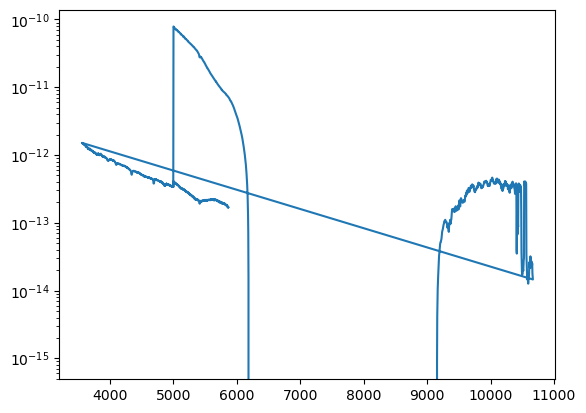

In [16]:
#for f in extracted_spectra:
f = extracted_spectra[1]
hdu = fits.open(f)
pyplot.plot(hdu[1].data['wavelength'], hdu[1].data['flux'])
pyplot.yscale('log')
pyplot.show()

In [ ]:
import pkg_resources
standard_files = glob(pkg_resources.resource_filename('banzai_floyds', 'data/standards/*.fits'))

In [ ]:
standard_files

In [ ]:
hdu[0].header

In [ ]:
from banzai_floyds.dbs import get_standard

In [ ]:
flux_standard = get_standard(hdu[0].header['RA'], hdu[0].header['DEC'], context.db_address)

In [ ]:
hdu = fits.open(extracted_spectra[3])
hdu[0].header['OBJECT']

In [ ]:
flux_standard

In [ ]:
image = factory.open({'path': './test_data/coj/en12/20200813/processed/coj2m002-en12-20200813-0014-e91-2d.fits.fz'}, context)

In [ ]:
from banzai_floyds.extract import get_wavelength_bins
image.wavelength_bins = get_wavelength_bins(image.wavelengths)

In [ ]:
from banzai_floyds.extract import bin_data
image.binned_data = bin_data(image.data, image.uncertainty, image.wavelengths,
                             image.orders, image.wavelength_bins)

In [ ]:
from banzai_floyds.extract import fit_profile_centers
profile_centers = fit_profile_centers(image.binned_data)

In [ ]:
profile_centers

In [ ]:
from matplotlib import pyplot
pyplot.imshow(image.wavelengths.data)

In [ ]:
profile_centers[0](7500)

In [ ]:
import scipy.interpolate
x, y = np.meshgrid(image.data.shape[1], image.data.shape[0])
centers = image.orders.centers(x)
#interpolator = scipy.interpolate.SmoothBivariateSpline(x, y, z)

In [ ]:
from matplotlib import pyplot
pyplot.imshow(image.data * image.orders.data, vmin=-5, vmax=300)

In [ ]:
image.meta